<a href="https://colab.research.google.com/github/magourram/algo_mass_data/blob/main/amd_project_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Image Classification by Author
Using the «Prado Museum Pictures» dataset of Project 3, the task is to implement a deep-learning-based system classifying pictures according to any reasonable organization of classes (e.g., by author–selecting a manageable subset of authors, or by support). Note that the dataset does not directly contain the picture images, but these can be downloaded separately using the work_image_url attribute of the  prado.csv file.

# Libraries

In [1]:
import os
import time
import json
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
import shutil
from shutil import copyfile
import zipfile
import random
from tqdm import tqdm
from IPython.display import Image
from google.colab import files

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, Input, AveragePooling2D, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

!pip install keras-tuner --upgrade --quiet
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch
from keras.metrics import AUC, Precision, Recall, Accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping ##

# Install kaggle
!pip install -q kaggle --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.0 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Kaggle API

In [3]:
start_time = time.time()

In [4]:
# To be replaced with 'xxxxxx'
os.environ['KAGGLE_USERNAME'] = "XXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXX"

In [5]:
# Create a new directory
new_directory_path = '/content/zip_file'
!mkdir "{new_directory_path}"

In [6]:
# Download dataset files and locatet it in the directory
%cd /content/zip_file
!kaggle datasets download -d maparla/prado-museum-pictures

/content/zip_file
100% 24.9G/24.9G [04:06<00:00, 93.7MB/s]
100% 24.9G/24.9G [04:06<00:00, 108MB/s] 


# Functions

In [7]:
# Function to extract images from a zipped file [remove]
def extract_file(zip_file_path, extraction_path):
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)
    path = os.path.join(extraction_path, 'images', 'images')
    print(f'The number of images in the folder is: {count_images_in_folder(path)}')

In [8]:
# Remove directories even if not empty
def remove_non_empty_directory(directory_path):
    try:
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_path}' and its contents have been successfully removed.")
    except Exception as e:
        print(f"Error: {e}")

In [9]:
# Count the number of images in folder
def count_images_in_folder(folder_path):
    extensions = ['jpg', 'jpeg', 'png']  # Add more if needed

    # Use glob to get a list of files with specified extensions
    image_files = [file for ext in extensions for file in glob.glob(os.path.join(folder_path, f'*.{ext}'))]

    # Count the number of image files
    num_images = len(image_files)

    return num_images

In [10]:
# Count the number of images in each subfolder after the re-allocation
def count_images_in_subfolders(root_folder, data_split):
    folder_path = os.path.join(root_folder, data_split)

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)

        if os.path.isdir(subfolder_path):
            # Counting the number of files with extension ".jpg" in each subfolder
            num_images = len([file for file in os.listdir(subfolder_path) if file.lower().endswith('.jpg')])

            # Printing the results
            print(f"Subfolder '{subfolder}' in '{data_split}' contains {num_images} images.")

In [11]:
# Function to plot images
def plot_images_from_folder(folder, num_cols=2):
    # Get a list of subfolders in the train folder
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]

    # Calculate number of rows required
    num_rows = (len(subfolders) + num_cols - 1) // num_cols

    # Set up the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    # Flatten the axes array to make it easier to iterate
    axes = axes.flatten()

    # Plot one image from each subfolder
    for i, subfolder in enumerate(subfolders):
        # Get the list of images in the subfolder
        images = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Plot the first image in the subfolder
        if images:
            img_path = images[0]
            img = mpimg.imread(img_path)

            # Extract subfolder name from the path for the plot title
            subfolder_name = os.path.basename(subfolder)

            # Plot the image
            axes[i].imshow(img)
            axes[i].set_title(subfolder_name)
            axes[i].axis('off')  # Turn off axis labels

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Setup

### Zip Extraction

In [12]:
# Set the path to zip file
zip_file_path = '/content/zip_file/prado-museum-pictures.zip'

# Set the path for the zip extraction
extraction_path = '/content/zip_file'
os.makedirs(extraction_path, exist_ok=True)

# Extract images using function
extract_file(zip_file_path, extraction_path)

The number of images in the folder is: 13472


### Accessing the csv file

In [13]:
# Reading the dataframe and make it accessible
extraction_path = "/content/zip_file"
df = pd.read_csv(os.path.join(extraction_path, "prado.csv"))

df["work_id"] = df['work_image_url'].apply(lambda x: x.split('/')[-1])

for _, row in df.iterrows():
    image_id = row["work_id"]
    image_path = os.path.join("images", image_id)

# Remove unneccesary columns
columns_to_drop = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
df.drop(columns=df.columns[columns_to_drop], inplace=True)

In [14]:
# Plot the generic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13487 entries, 0 to 13486
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     13487 non-null  object
 1   author_id  12360 non-null  object
 2   work_id    13487 non-null  object
dtypes: object(3)
memory usage: 316.2+ KB


### Analysis on the authors

In [15]:
# Create a copy of the original dataframe and remove empty cells from author_id
df_f = df[['author_id', 'author', 'work_id']].dropna(subset=['author_id'])
df_f = df_f.reset_index(drop=True)

# Create a new column 'total_occurrences' based on 'author_id' counts
df_f['total_occurrences'] = df_f['author_id'].map(df_f['author_id'].value_counts())

# Extract the id related to Anonimous artists and remove rows related to it
anonimo_author_id = df_f.loc[df_f['author'] == 'Anónimo', 'author_id'].iloc[0]
df_f = df_f[df_f['author_id'] != anonimo_author_id].reset_index(drop=True)

df_f

author_id  \
0     b218fee4-053b-4656-8577-9aa001ad1989   
1     b20a5ee9-2ebd-4e60-aadc-e91e7867cb12   
2     26861819-ff88-4fde-8a37-56db9e1c1ba4   
3     a8c659ad-d887-4703-8af3-1832dfc88eb7   
4     521b82d6-6848-4f7d-96dc-3b8f102dd8b5   
...                                    ...   
9656  361ddf6c-ba4f-45ef-a835-644ddc70ee8a   
9657  d351c3c1-e89b-49cf-900d-24085ed1908f   
9658  9e420297-9fb9-4ef3-b128-96596d5dc191   
9659  d984cdeb-020c-41f9-ae68-3285aebfa25a   
9660  39568a17-81b5-4d6f-84fa-12db60780812   

                                        author  \
0                    Bayeu y Subías, Francisco   
1                       Crespi, Giuseppe Maria   
2                     Cronenburch, Adriaen van   
3                 González Velázquez, Zacarías   
4     Obra copiada de Cano de la Peña, Eduardo   
...                                        ...   
9656                           Julien de Parma   
9657                 Atribuido Falck, Jeremías   
9658                  Atribuido Kiyonobu, Tori   
9659                            García, Sergio   
9660            Goya y Lucientes, Francisco de   

                                       work_id  total_occurrences  
0     404387d6-a52c-4477-b598-de2a2d5a3d55.jpg                446  
1     589ee4a3-28fa-4977-a84d-7326f5c9aeb3.jpg                  4  
2     4a8bab74-ca91-450a-b5b7-39dd61e2d7f3.jpg                  4  
3     9af5b176-b4d3-4930-854b-5b5f252829f1.jpg                 29  
4     4c494f0a-d5ae-45ca-826b-59f4b5fd4398.jpg                 10  
...                                        ...                ...  
9656  b184ebe1-c79e-482c-b91c-028e945aa66c.jpg                  2  
9657  c62f7f3e-3ad3-4d9e-9586-b0b389b2d032.jpg                  1  
9658  6c28accf-e0c0-4bc0-b4c6-3fbb282bcbd8.jpg                  1  
9659  b4126fb6-c5ac-40e3-89a1-d1578914c09b.jpg                  1  
9660  e8d785a8-1407-4203-b837-2d01e82a36cb.jpg               1097  

[9661 rows x 4 columns]

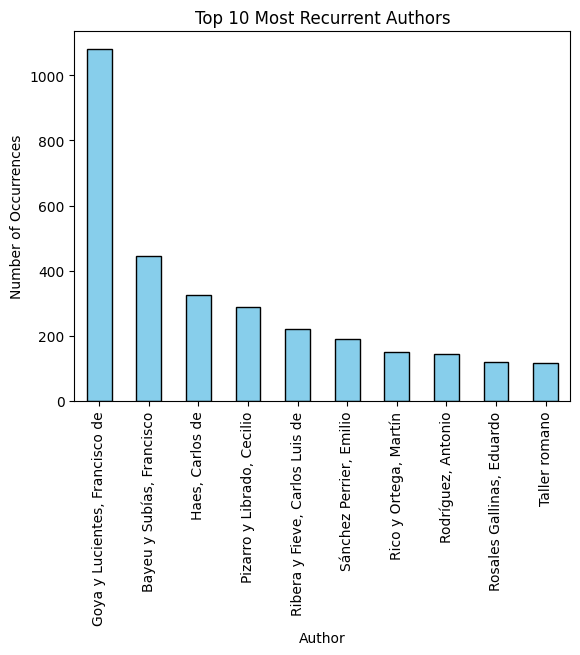

In [16]:
# Get the most recurrent authors
top_authors = df_f['author'].value_counts().head(10)

# Plot
top_authors.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Author')
plt.ylabel('Number of Occurrences')
plt.title('Top 10 Most Recurrent Authors')

# Show the plot
plt.show()

In [17]:
# Create a dataframe with just authors_id and authors_name as reference
authors_df = df_f[['author_id', 'author']]
authors_df = authors_df.drop_duplicates(subset='author_id').reset_index(drop=True)
authors_df

author_id  \
0     b218fee4-053b-4656-8577-9aa001ad1989   
1     b20a5ee9-2ebd-4e60-aadc-e91e7867cb12   
2     26861819-ff88-4fde-8a37-56db9e1c1ba4   
3     a8c659ad-d887-4703-8af3-1832dfc88eb7   
4     521b82d6-6848-4f7d-96dc-3b8f102dd8b5   
...                                    ...   
1796  f2259d91-6fe8-4bec-acba-456be42565ea   
1797  5cdf0673-76d3-4151-acf5-fbe95c1915a7   
1798  d351c3c1-e89b-49cf-900d-24085ed1908f   
1799  9e420297-9fb9-4ef3-b128-96596d5dc191   
1800  d984cdeb-020c-41f9-ae68-3285aebfa25a   

                                        author  
0                    Bayeu y Subías, Francisco  
1                       Crespi, Giuseppe Maria  
2                     Cronenburch, Adriaen van  
3                 González Velázquez, Zacarías  
4     Obra copiada de Cano de la Peña, Eduardo  
...                                        ...  
1796                              Pavon, Luigi  
1797                            Pagano, Matteo  
1798                 Atribuido Falck, Jeremías  
1799                  Atribuido Kiyonobu, Tori  
1800                            García, Sergio  

[1801 rows x 2 columns]

In [18]:
# Merge authors_df with df_f based on 'author_id', keeping all occurrences in df_f
df_merged_final = pd.merge(
    authors_df[['author_id', 'author']],
    df_f[['author_id', 'total_occurrences']].drop_duplicates(subset='author_id').reset_index(drop=True),
    on='author_id',
    how='left')

df_merged_final

author_id  \
0     b218fee4-053b-4656-8577-9aa001ad1989   
1     b20a5ee9-2ebd-4e60-aadc-e91e7867cb12   
2     26861819-ff88-4fde-8a37-56db9e1c1ba4   
3     a8c659ad-d887-4703-8af3-1832dfc88eb7   
4     521b82d6-6848-4f7d-96dc-3b8f102dd8b5   
...                                    ...   
1796  f2259d91-6fe8-4bec-acba-456be42565ea   
1797  5cdf0673-76d3-4151-acf5-fbe95c1915a7   
1798  d351c3c1-e89b-49cf-900d-24085ed1908f   
1799  9e420297-9fb9-4ef3-b128-96596d5dc191   
1800  d984cdeb-020c-41f9-ae68-3285aebfa25a   

                                        author  total_occurrences  
0                    Bayeu y Subías, Francisco                446  
1                       Crespi, Giuseppe Maria                  4  
2                     Cronenburch, Adriaen van                  4  
3                 González Velázquez, Zacarías                 29  
4     Obra copiada de Cano de la Peña, Eduardo                 10  
...                                        ...                ...  
1796                              Pavon, Luigi                  1  
1797                            Pagano, Matteo                  1  
1798                 Atribuido Falck, Jeremías                  1  
1799                  Atribuido Kiyonobu, Tori                  1  
1800                            García, Sergio                  1  

[1801 rows x 3 columns]

### Setting up a sample of images


In [19]:
# Filter rows with 'total_occurrences' at least minimum_img (number of images per author)
minimum_img = 200 #to be adjusted number of images for each author
df_merged_final_1 = df_merged_final[df_merged_final['total_occurrences'] >= minimum_img].reset_index(drop=True)
df_merged_final_1

author_id                          author  \
0  b218fee4-053b-4656-8577-9aa001ad1989       Bayeu y Subías, Francisco   
1  39568a17-81b5-4d6f-84fa-12db60780812  Goya y Lucientes, Francisco de   
2  5e2996c9-53ec-4b75-ac76-eb4ead2cf6c0  Ribera y Fieve, Carlos Luis de   
3  1e7197fc-e941-418b-a0c9-4ce34ce633e9                 Haes, Carlos de   
4  0b7d7dd0-cb66-4ee0-9f01-1cc526587980      Pizarro y Librado, Cecilio   

   total_occurrences  
0                446  
1               1097  
2                222  
3                326  
4                290

In [20]:
# Settings
total_number_classes = len(df_merged_final_1) #depending on minimum_img
print("Number of rows in the DataFrame:", total_number_classes)

Number of rows in the DataFrame: 5


In [21]:
# Train to be adjusted; val and test same ratio
train_ratio = 0.6
val_ratio = round((1 - train_ratio)/2,2)
test_ratio = round(1 - train_ratio - val_ratio,2)

In [22]:
# Results after setting (macro level)
print("Total images at disposable:", total_number_classes * minimum_img, "\n")
print("Images used in training:", total_number_classes * minimum_img * train_ratio)
print("Images used in validation:", total_number_classes * minimum_img * val_ratio)
print("Images used in test:", total_number_classes * minimum_img * test_ratio, "\n")

# Results after setting (micro level)
print("Images in each training class:", (total_number_classes * minimum_img * train_ratio) / total_number_classes)
print("Images in each validation class:", (total_number_classes * minimum_img * val_ratio) / total_number_classes)
print("Images in each test class:", (total_number_classes * minimum_img * test_ratio) / total_number_classes)

Total images at disposable: 1000 

Images used in training: 600.0
Images used in validation: 200.0
Images used in test: 200.0 

Images in each training class: 120.0
Images in each validation class: 40.0
Images in each test class: 40.0


### Classes definition

In [23]:
classes_names = df_merged_final_1['author'].tolist()
print(classes_names)

classes_id = df_merged_final_1['author_id'].tolist()
print(classes_id)

['Bayeu y Subías, Francisco', 'Goya y Lucientes, Francisco de', 'Ribera y Fieve, Carlos Luis de', 'Haes, Carlos de', 'Pizarro y Librado, Cecilio']
['b218fee4-053b-4656-8577-9aa001ad1989', '39568a17-81b5-4d6f-84fa-12db60780812', '5e2996c9-53ec-4b75-ac76-eb4ead2cf6c0', '1e7197fc-e941-418b-a0c9-4ce34ce633e9', '0b7d7dd0-cb66-4ee0-9f01-1cc526587980']


### Extraction of work_id and check existence for consistency

In [24]:
np.random.seed(42)

result_df = pd.DataFrame()

# Loop through each author_id in the list
for id_value in classes_id:

    # Extract a sample
    all_rows = df[df['author_id'] == id_value]

    # Extract work_id from sampled rows
    work_ids = all_rows['work_id'].tolist()

    # Check if related images exist in another folder
    existing_work_ids = [work_id for work_id in work_ids if os.path.exists(f"/content/zip_file/images/images/{work_id}")]

    # If there are more than minimum_img existing images, sample randomly
    if len(existing_work_ids) >= minimum_img:
        sampled_work_ids = np.random.choice(existing_work_ids, size=minimum_img, replace=False)
    else:
        # If there are fewer than minimum_img existing images, sample with replacement
        sampled_work_ids = np.random.choice(existing_work_ids, size=minimum_img, replace=False)

    # Filter rows based on the sampled work_ids
    sampled_rows = all_rows[all_rows['work_id'].isin(sampled_work_ids)]

    result_df = pd.concat([result_df, sampled_rows], ignore_index=True)

result_df = result_df.sample(frac=1, random_state=42).reset_index(drop=True)

result_df

author                             author_id  \
0    Ribera y Fieve, Carlos Luis de  5e2996c9-53ec-4b75-ac76-eb4ead2cf6c0   
1                   Haes, Carlos de  1e7197fc-e941-418b-a0c9-4ce34ce633e9   
2                   Haes, Carlos de  1e7197fc-e941-418b-a0c9-4ce34ce633e9   
3                   Haes, Carlos de  1e7197fc-e941-418b-a0c9-4ce34ce633e9   
4    Ribera y Fieve, Carlos Luis de  5e2996c9-53ec-4b75-ac76-eb4ead2cf6c0   
..                              ...                                   ...   
995       Bayeu y Subías, Francisco  b218fee4-053b-4656-8577-9aa001ad1989   
996  Goya y Lucientes, Francisco de  39568a17-81b5-4d6f-84fa-12db60780812   
997      Pizarro y Librado, Cecilio  0b7d7dd0-cb66-4ee0-9f01-1cc526587980   
998  Ribera y Fieve, Carlos Luis de  5e2996c9-53ec-4b75-ac76-eb4ead2cf6c0   
999       Bayeu y Subías, Francisco  b218fee4-053b-4656-8577-9aa001ad1989   

                                      work_id  
0    0de9bcfc-fac1-49cc-9de2-c772502cdf9f.jpg  
1    f5085bdf-2cae-4a74-88f3-699b6c4e4235.jpg  
2    93409ab6-98f5-455a-bf44-e518b5f0c3a3.jpg  
3    e324d2a1-75b7-4a06-8dfe-4cda53d944d1.jpg  
4    40669a8b-3fbd-4f04-8ba7-f94a9b8a401c.jpg  
..                                        ...  
995  de381457-ebcc-4dc0-a20c-ad2c3e9cc3ad.jpg  
996  ff427de3-4830-4b93-9bdb-c829ddfdb5ca.jpg  
997  295c713b-35ee-4f4c-a5d0-31ce0bb25e3d.jpg  
998  42724b1d-64b7-456f-a6ef-9bc4b4269112.jpg  
999  c71af919-81b9-46b9-af4c-cee3087e00e3.jpg  

[1000 rows x 3 columns]

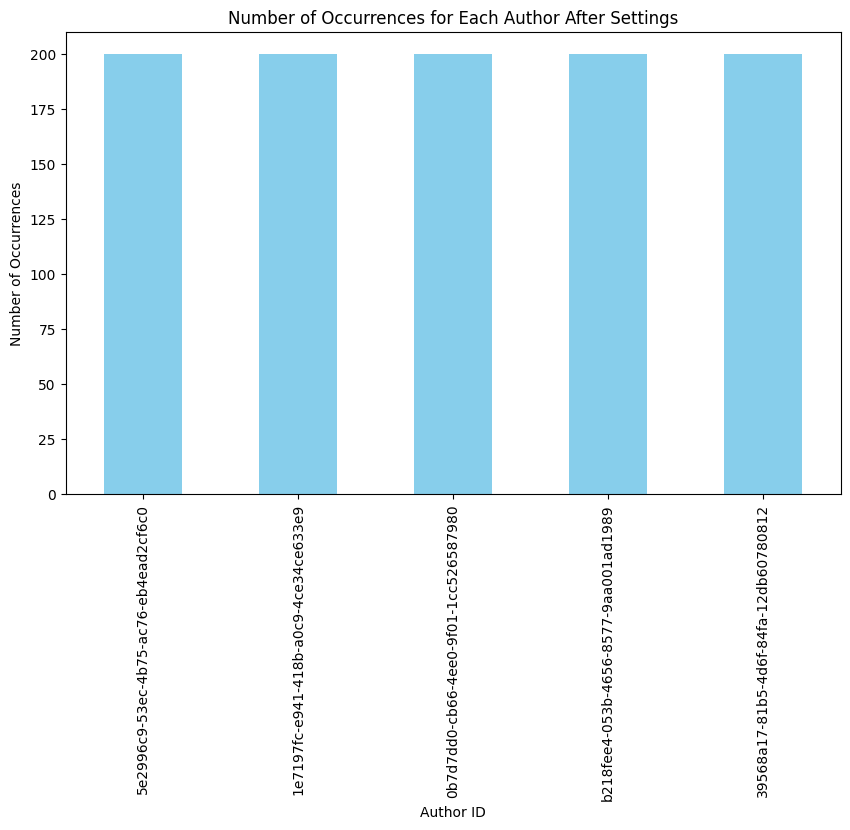

In [25]:
# Extract list of the useful id related to images
work_id_list = result_df['work_id'].to_list()
len(work_id_list)

# Count the occurrences of each author in result_df
author_counts = result_df['author_id'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
author_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Occurrences for Each Author After Settings')
plt.xlabel('Author ID')
plt.ylabel('Number of Occurrences')
plt.show()

In [26]:
# Loop through the work_ids list and check if all file exists
for file_name in work_id_list:
    file_path = os.path.join(extraction_path, 'images', 'images', file_name)

    if not os.path.exists(file_path):
        print(f"File {file_name} does not exist in the directory.")

all_files_exist = all(os.path.exists(os.path.join(extraction_path, 'images', 'images', file_name)) for file_name in work_ids)
print(f"All files exist? {all_files_exist}")

All files exist? True


In [27]:
# Loop through the files in the source path and remove non-selected art works
for file_name in os.listdir(os.path.join(extraction_path, 'images', 'images')):
    file_path = os.path.join(extraction_path, 'images', 'images', file_name)

    if file_name not in work_id_list:
        os.remove(file_path)

print("Files removed successfully.")

Files removed successfully.


In [28]:
# Creating a dataframe with the data related to the work_id_list
result_df_final = result_df[result_df['work_id']==work_id_list]

# Add a column with the path to the images
result_df_final['image_path'] = result_df_final['work_id'].apply(lambda filename: os.path.join(extraction_path, 'images', 'images', filename))

# Merge df with the one containing just the ten authors
result_df_final = pd.merge(result_df_final, df_merged_final, on='author_id').drop('author_x', axis=1).rename(columns={'author_y': 'author'})

### Moving images

In [29]:
'''
shutil.rmtree('/content/prado_images')
'''

"\nshutil.rmtree('/content/prado_images')\n"

In [30]:
# Define the paths
source_folder = os.path.join(extraction_path, 'images', 'images')
output_folder = '/content/prado_images'

# Set a random seed for replicability
random_seed = 42

# Create train, test, and validation splits
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio + val_ratio, random_state=random_seed)
for train_index, test_validation_index in sss_test.split(result_df_final, result_df_final['author']):
    train_df = result_df_final.iloc[train_index]
    test_validation_df = result_df_final.iloc[test_validation_index]

sss_validation = StratifiedShuffleSplit(n_splits=1, test_size= val_ratio / (test_ratio + val_ratio), random_state=random_seed)
for test_index, validation_index in sss_validation.split(test_validation_df, test_validation_df['author']):
    test_df = test_validation_df.iloc[test_index]
    validation_df = test_validation_df.iloc[validation_index]

# Create train, test, and validation folders
for split in ['train', 'test', 'validation']:
    split_folder = os.path.join(output_folder, split)
    os.makedirs(split_folder, exist_ok=True)

    # Create subfolders for each author
    for author in result_df_final['author'].unique():
        author_folder = os.path.join(split_folder, str(author))
        os.makedirs(author_folder, exist_ok=True)

# Move images to their respective folders
for split, current_df in zip(['train', 'test', 'validation'], [train_df, test_df, validation_df]):
    for index, row in current_df.iterrows():
        source_path = os.path.join(source_folder, row['work_id'])
        destination_path = os.path.join(output_folder, split, str(row['author']), os.path.basename(row['image_path']))
        shutil.copy(source_path, destination_path)

In [31]:
# Count images in the "train", "valiadtion", and "test" subfolders
print("---   TRAIN   ---")
count_images_in_subfolders(output_folder, "train")
print("---------------------")
print("---   VALIDATION   ---")
count_images_in_subfolders(output_folder, "validation")
print("---------------------")
print("---   TEST   ---")
count_images_in_subfolders(output_folder, "test")
print("---------------------")

---   TRAIN   ---
Subfolder 'Bayeu y Subías, Francisco' in 'train' contains 120 images.
Subfolder 'Goya y Lucientes, Francisco de' in 'train' contains 120 images.
Subfolder 'Haes, Carlos de' in 'train' contains 120 images.
Subfolder 'Ribera y Fieve, Carlos Luis de' in 'train' contains 120 images.
Subfolder 'Pizarro y Librado, Cecilio' in 'train' contains 120 images.
---------------------
---   VALIDATION   ---
Subfolder 'Bayeu y Subías, Francisco' in 'validation' contains 40 images.
Subfolder 'Goya y Lucientes, Francisco de' in 'validation' contains 40 images.
Subfolder 'Haes, Carlos de' in 'validation' contains 40 images.
Subfolder 'Ribera y Fieve, Carlos Luis de' in 'validation' contains 40 images.
Subfolder 'Pizarro y Librado, Cecilio' in 'validation' contains 40 images.
---------------------
---   TEST   ---
Subfolder 'Bayeu y Subías, Francisco' in 'test' contains 40 images.
Subfolder 'Goya y Lucientes, Francisco de' in 'test' contains 40 images.
Subfolder 'Haes, Carlos de' in 'tes

In [32]:
'''
# Remove temporary image folder
remove_non_empty_directory('/content/zip_file/images')
'''

"\n# Remove temporary image folder\nremove_non_empty_directory('/content/zip_file/images')\n"

### Plot images

In [33]:
train_path = '/content/prado_images/train'
validation_path = '/content/prado_images/validation'
test_path = '/content/prado_images/test'

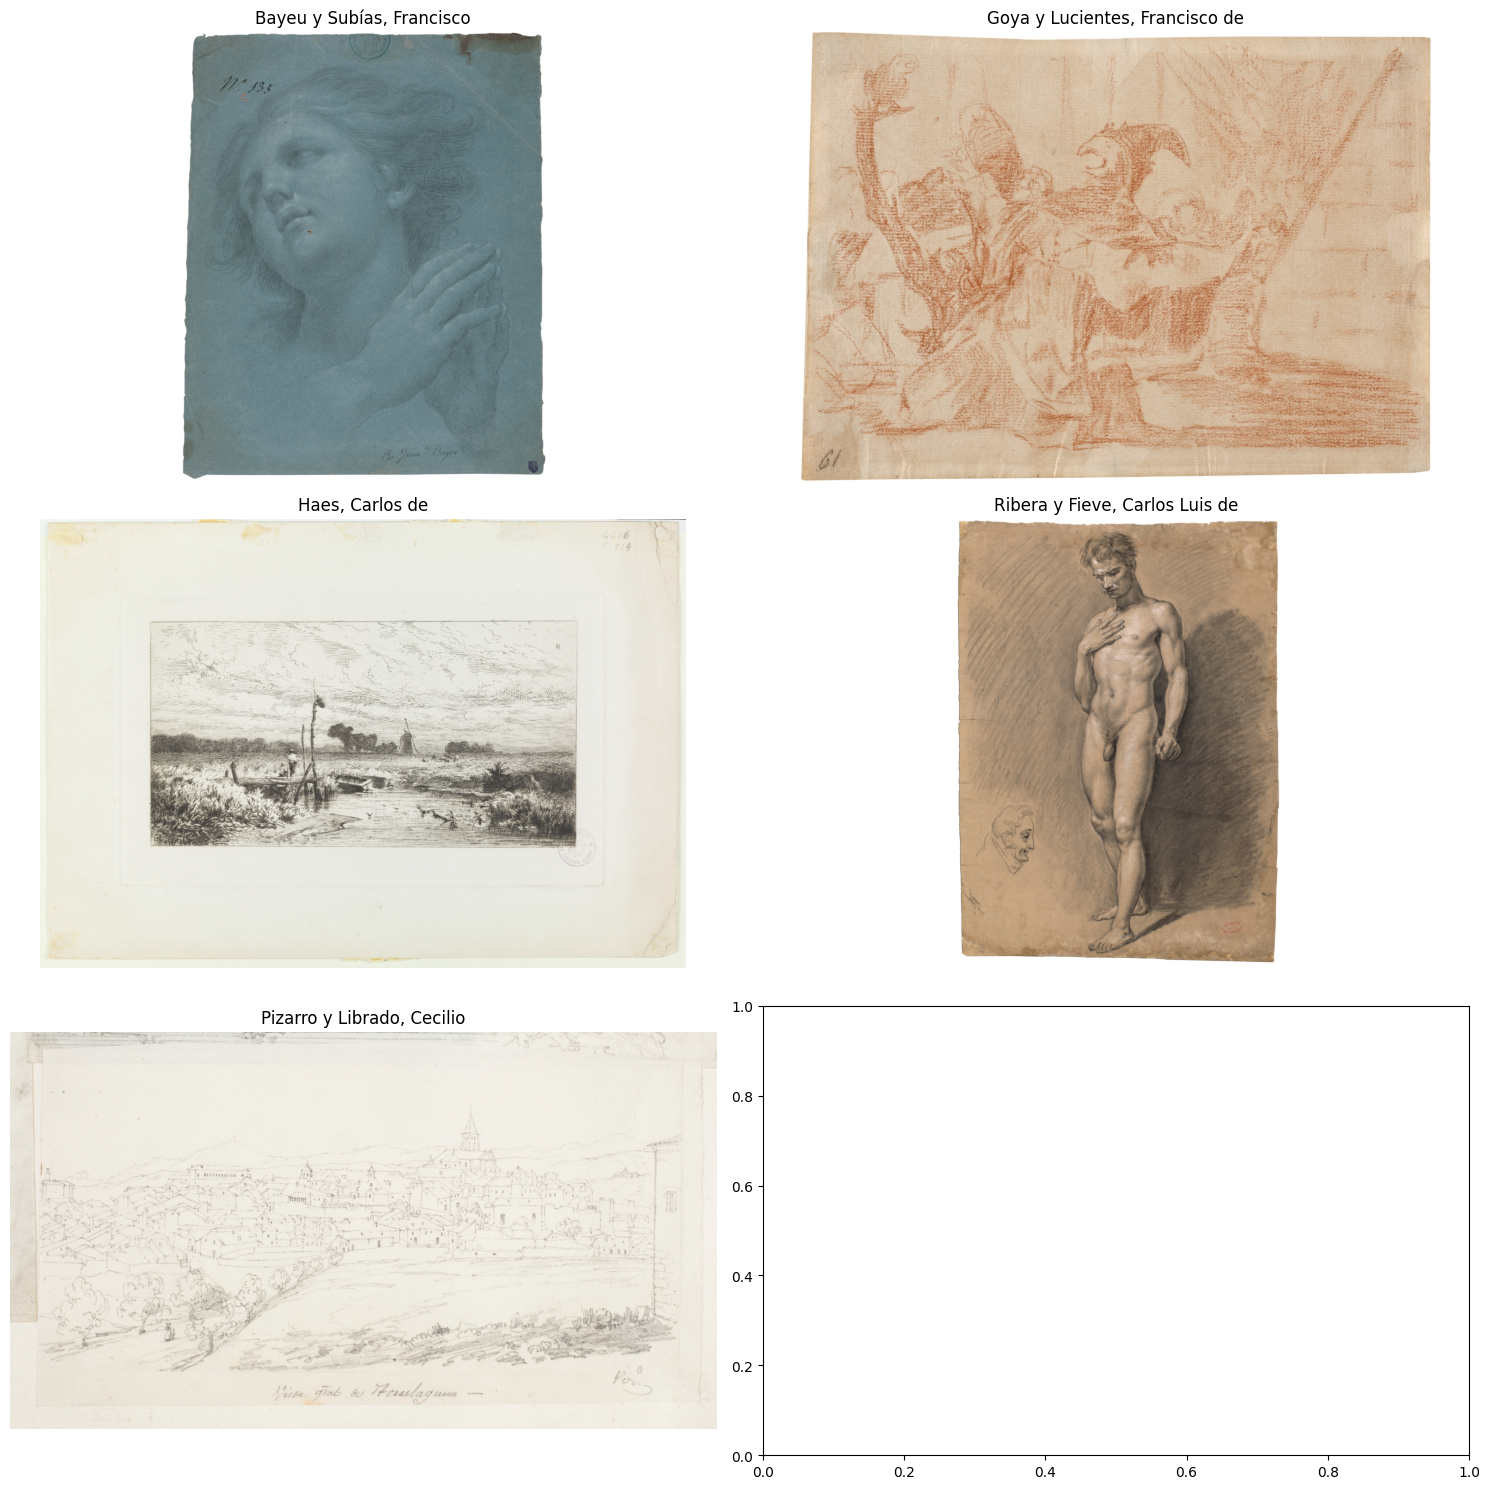

In [34]:
#Train
plot_images_from_folder(train_path)

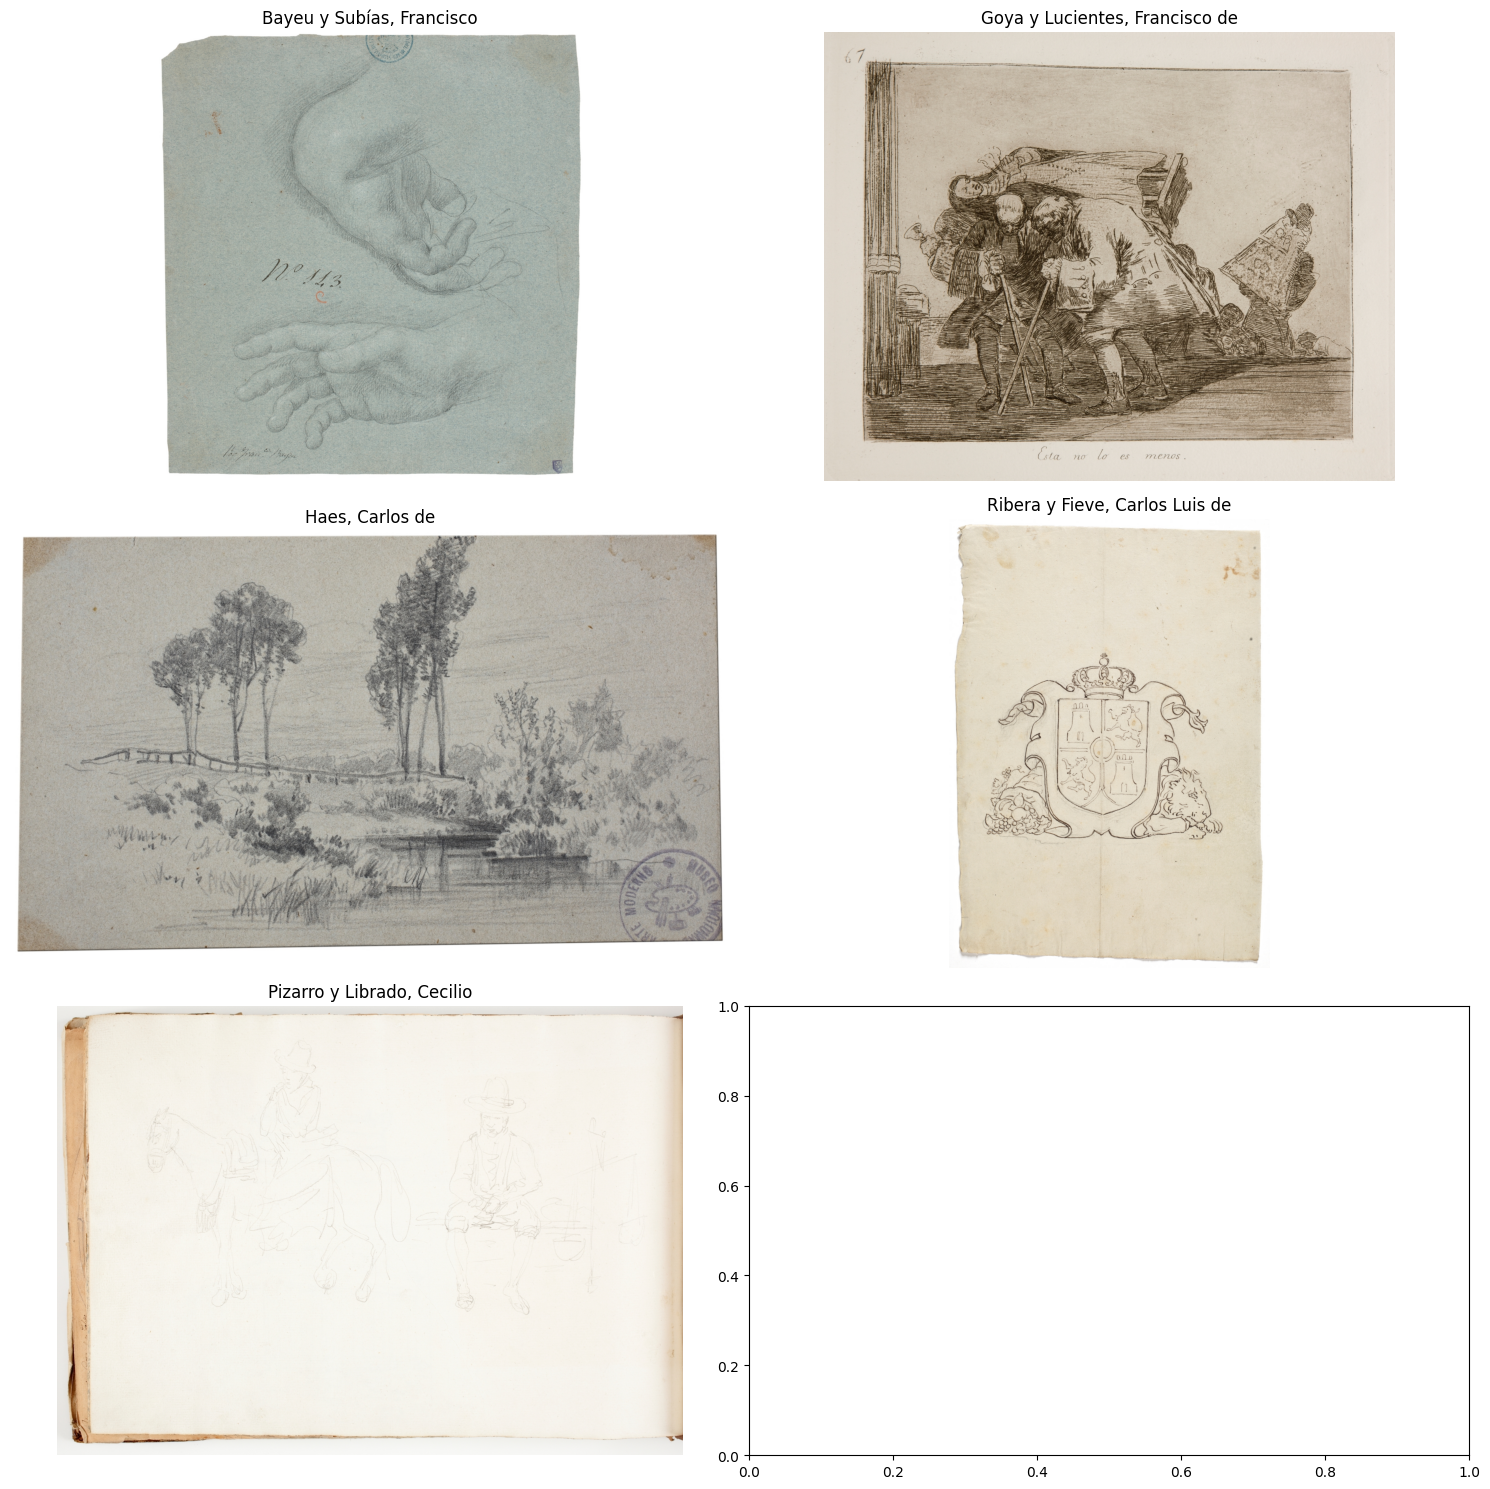

In [35]:
#Test
plot_images_from_folder(validation_path)

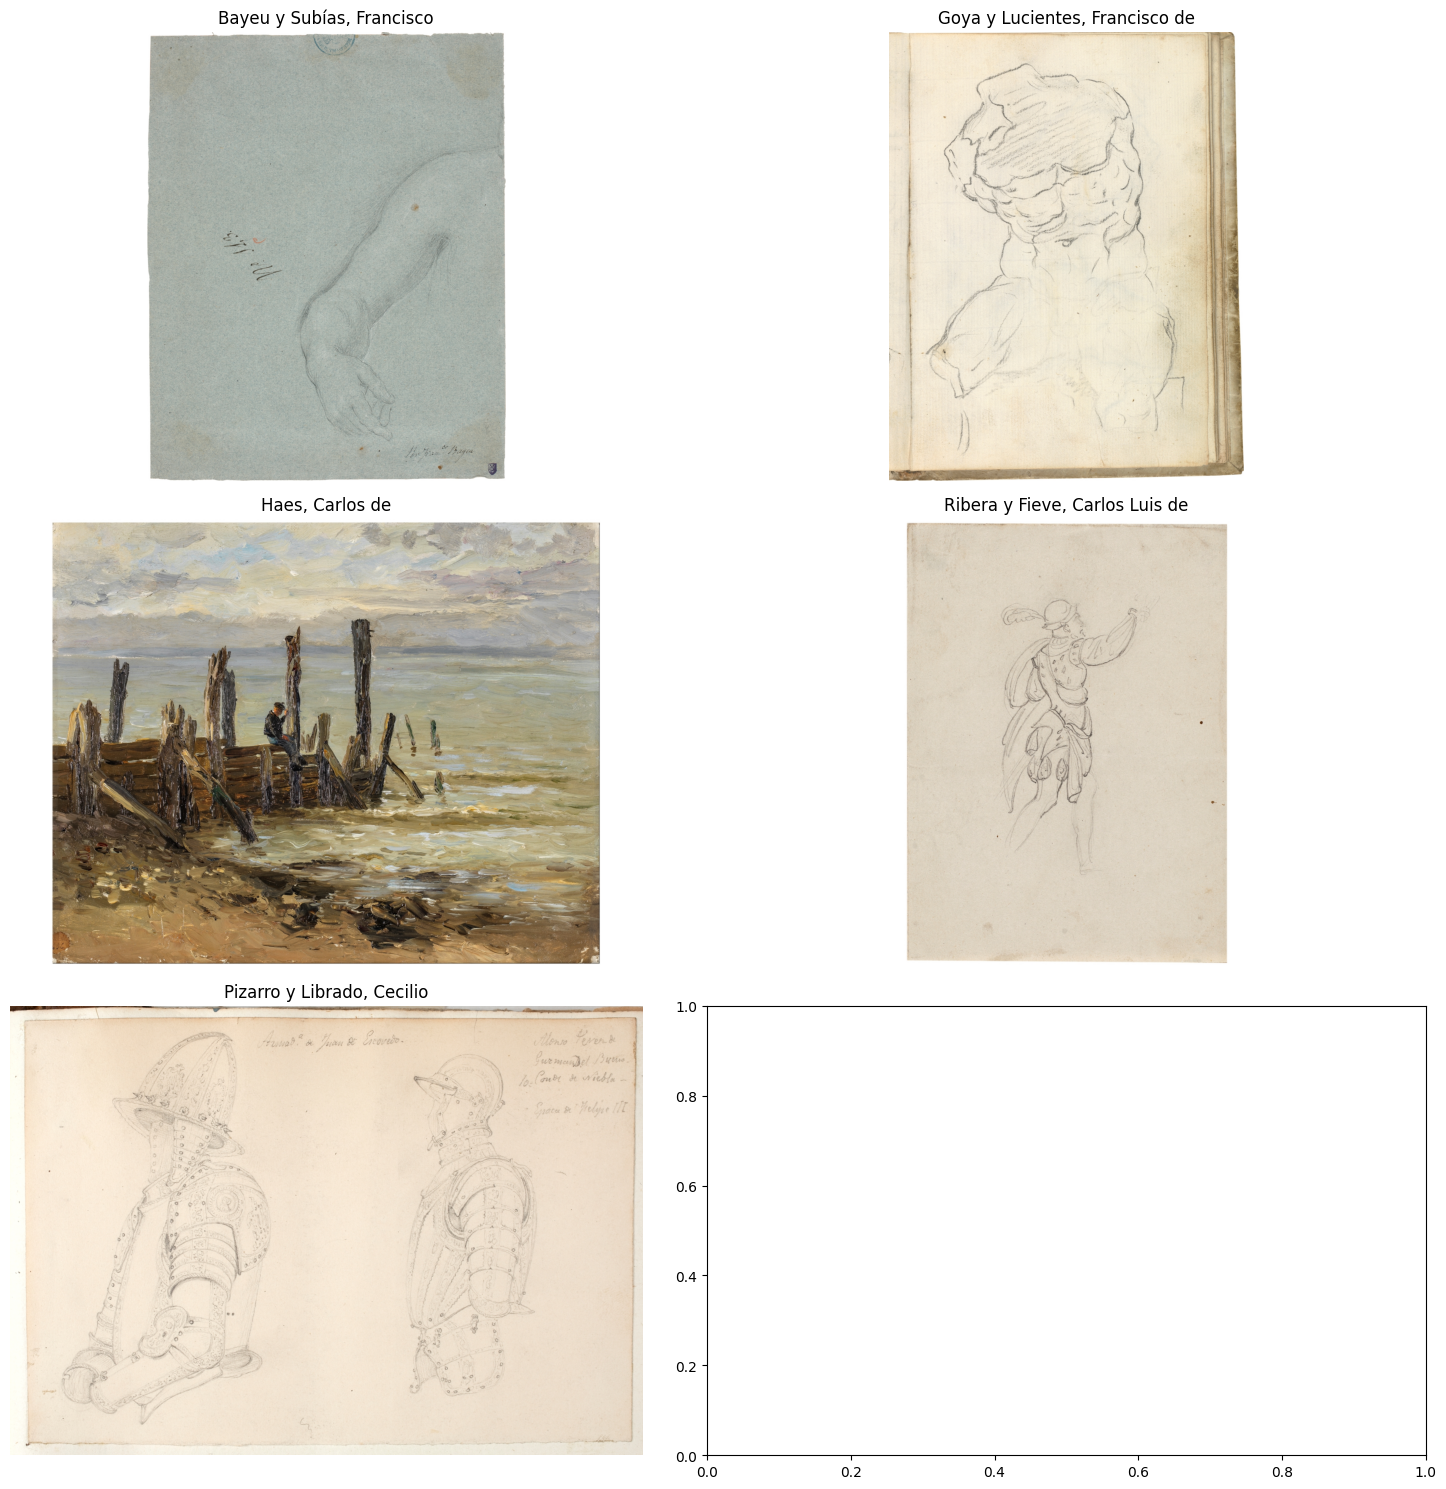

In [36]:
#Validation
plot_images_from_folder(test_path)

## Image processing

In [37]:
# Definition of parameters
HEIGHT = 64
WIDTH = 64
BATCH = 20
EPOCHS = 20

In [38]:
# Generation of tf dataset from images in the directories
train_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size = (HEIGHT, WIDTH),
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
    seed=42,
    shuffle=True,
    batch_size=BATCH
    )

validation_data = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    image_size = (HEIGHT, WIDTH),
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
    seed=42,
    shuffle=True,
    batch_size=BATCH
    )

test_data = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(HEIGHT, WIDTH),
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
    seed=42,
    shuffle=True,
    batch_size=BATCH
)

Found 600 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 200 files belonging to 5 classes.


In [39]:
# Extraction of classes from tf.Dataset
classes = train_data.class_names
classes

['Bayeu y Subías, Francisco',
 'Goya y Lucientes, Francisco de',
 'Haes, Carlos de',
 'Pizarro y Librado, Cecilio',
 'Ribera y Fieve, Carlos Luis de']

In [40]:
# Compute class weights
weights_class = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes)

weights_class = {i: 1.0 for i in dict(enumerate(weights_class)).keys()}
weights_class

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

## EDA

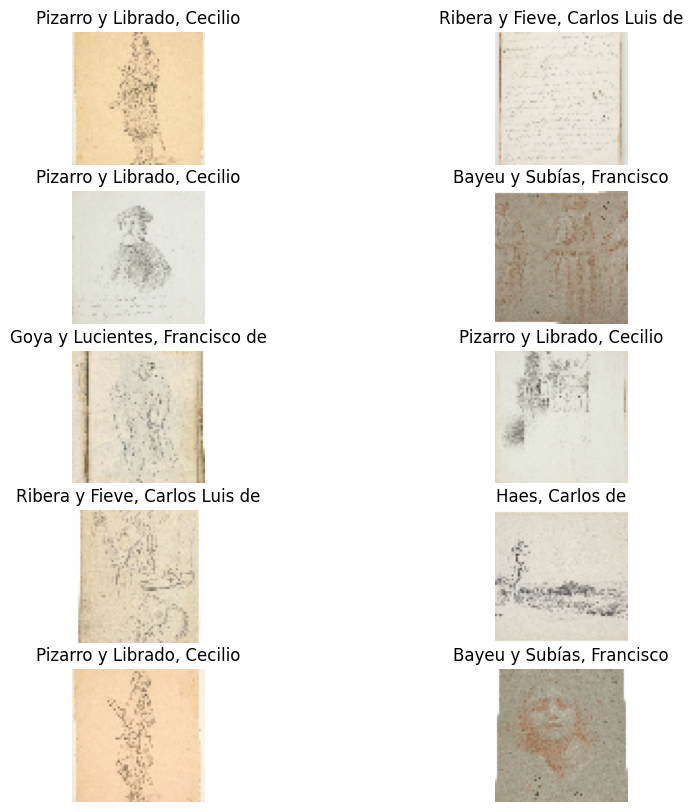

In [41]:
# Plotting images from train data
plt.figure(figsize=(10,10))

for images, labels in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(5,2,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
    plt.axis('off')

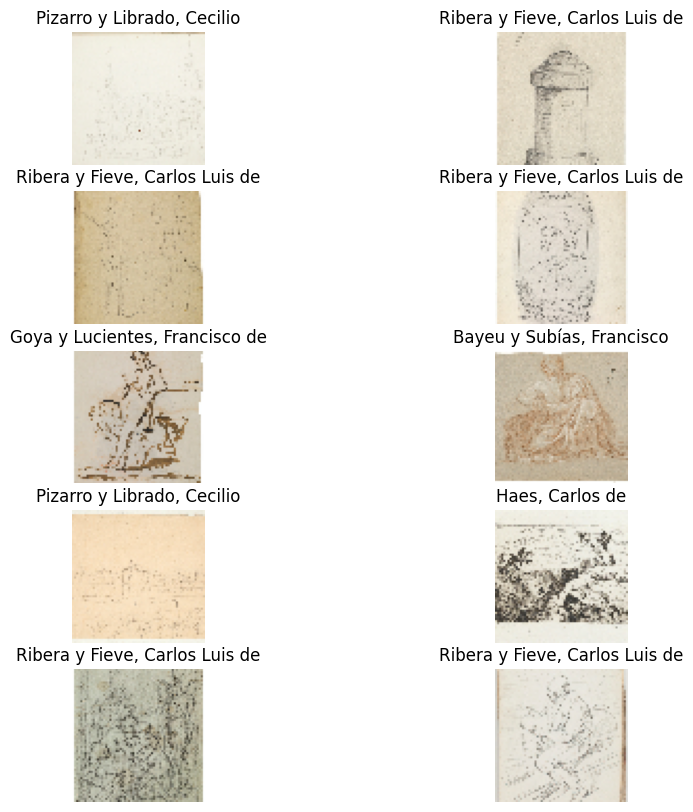

In [42]:
# Plotting images from validation data
plt.figure(figsize=(10,10))

for images, labels in validation_data.take(1):
  for i in range(10):
    ax = plt.subplot(5,2,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
    plt.axis('off')

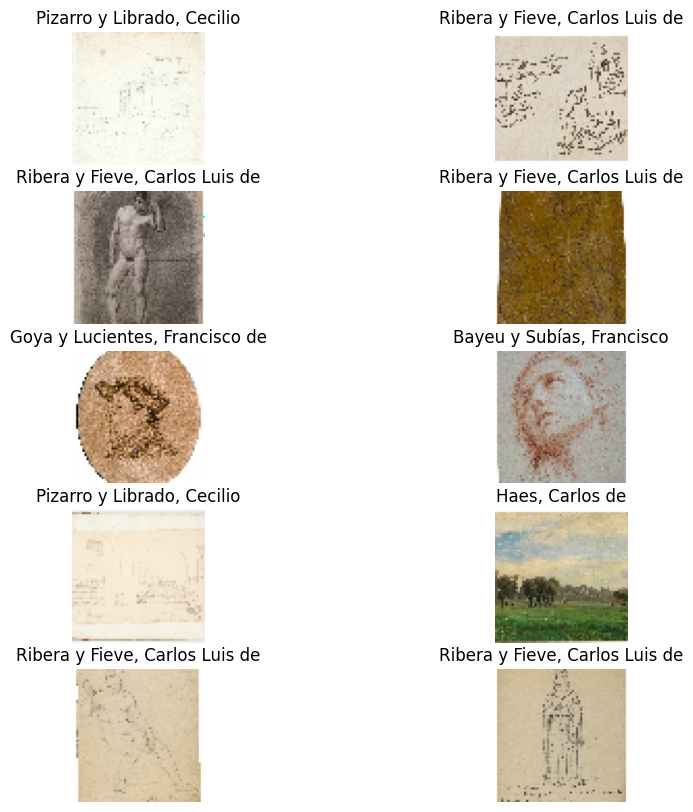

In [43]:
# Plotting images from test data
plt.figure(figsize=(10,10))

for images, labels in test_data.take(1):
  for i in range(10):
    ax = plt.subplot(5,2,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
    plt.axis('off')

## Model preparation and deployment

In [44]:
# Data augmentation pipeline
train_aug = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape = (HEIGHT, WIDTH, 3)), #random horizontal and vertical flips to the input images
    #layers.experimental.preprocessing.RandomZoom(height_factor=(-0.05, -0.15), width_factor=(-0.05, -0.15),fill_mode='nearest'), #layer introduces random zooming to the images and fills empty areas in zooms
    #layers.RandomBrightness(0.2), #adjusts the brightness of the images
    layers.RandomContrast(0.2), #adjusts the contrast of the images
    layers.RandomTranslation(0.05, 0.05), #random translations to the images in both the horizontal and vertical directions
    layers.RandomRotation(0.2) #random rotations to the images
])

In [45]:
# Dynamic tuning of performance-related parameters
AUTOTUNE = tf.data.AUTOTUNE

# Optimizing the data loading pipeline for training and validation by caching, shuffling, and prefetching the dataset elements
train_data = train_data.cache().shuffle(1000, seed=random_seed).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

# Setting early stopping function on training stage
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Base model

In [46]:
# Model definition
def base_model():
  model = Sequential()
  #model.add(train_aug)
  model.add(layers.Rescaling(1./255, input_shape = (HEIGHT, WIDTH, 3)))

  model.add(layers.Conv2D(16, kernel_size=(3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(32, kernel_size=(3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation = 'relu'))
  model.add(layers.Dense(len(classes)))

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy'])
  return model

In [47]:
b_model = base_model()
b_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)       

In [48]:
# Training
base_history = b_model.fit(train_data,
                           validation_data = validation_data,
                           epochs = EPOCHS,
                           class_weight = weights_class,
                           callbacks=[early_stopping])

Epoch 1/20
30/30 [==============================] - 32s 444ms/step - loss: 1.5150 - accuracy: 0.2750 - val_loss: 1.3854 - val_accuracy: 0.3450
Epoch 2/20
30/30 [==============================] - 3s 105ms/step - loss: 1.2947 - accuracy: 0.4267 - val_loss: 1.3220 - val_accuracy: 0.4100
Epoch 3/20
30/30 [==============================] - 3s 93ms/step - loss: 1.1172 - accuracy: 0.5600 - val_loss: 1.0487 - val_accuracy: 0.5850
Epoch 4/20
30/30 [==============================] - 3s 91ms/step - loss: 1.0181 - accuracy: 0.5950 - val_loss: 1.1406 - val_accuracy: 0.6550
Epoch 5/20
30/30 [==============================] - 3s 90ms/step - loss: 0.8773 - accuracy: 0.6733 - val_loss: 0.9955 - val_accuracy: 0.6200
Epoch 6/20
30/30 [==============================] - 4s 130ms/step - loss: 0.8087 - accuracy: 0.6867 - val_loss: 0.8638 - val_accuracy: 0.6850
Epoch 7/20
30/30 [==============================] - 3s 89ms/step - loss: 0.6592 - accuracy: 0.7633 - val_loss: 0.9064 - val_accuracy: 0.6300
Epoch 8/2

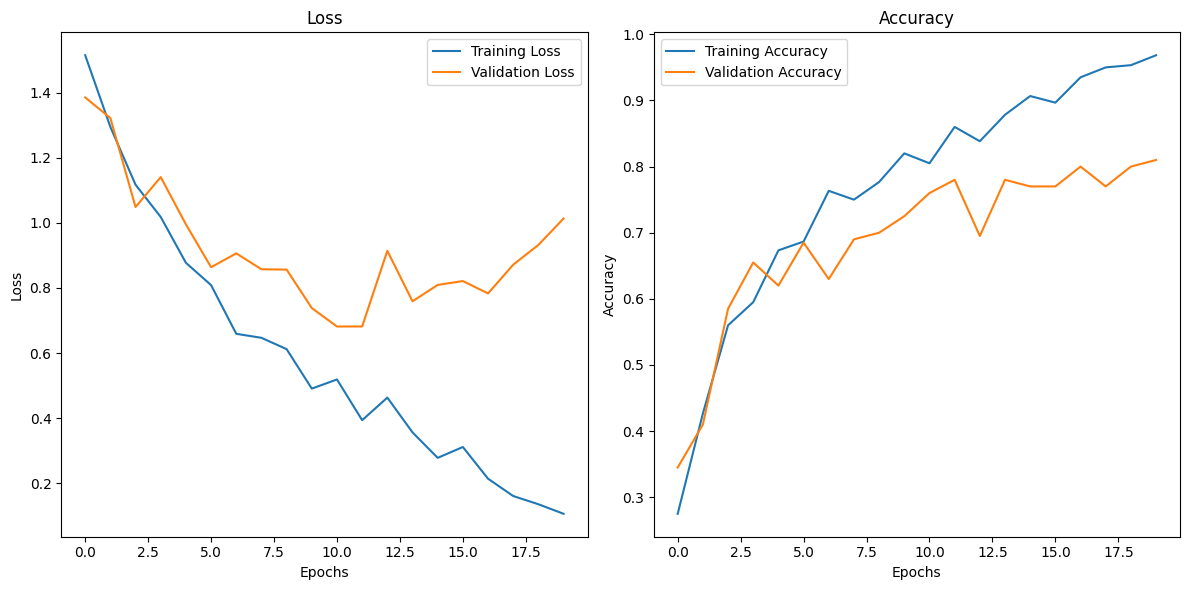

In [49]:
# Plotting performance model
history_df = pd.DataFrame(base_history.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(history_df['loss'], label='Training Loss')
axes[0].plot(history_df['val_loss'], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_df['accuracy'], label='Training Accuracy')
axes[1].plot(history_df['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [50]:
# Prediction
trues = []
preds = []
for img, label in test_data:
  pred = b_model.predict(img, verbose=0)
  pred = pred.argmax(axis=1)
  trues.append(label[0])
  preds.append(pred[0])

In [51]:
# Prediction measures results
print("F1-Score:", round(f1_score(trues, preds, average='micro', zero_division=1),3))
print("Recall score:", round(recall_score(trues, preds, average='micro', zero_division=1),3))
print("Precision score:", round(precision_score(trues, preds, average='micro', zero_division=1),3))

F1-Score: 0.7
Recall score: 0.7
Precision score: 0.7


In [52]:
# Model loss value & metrics values in test mode
b_model.evaluate(test_data)

10/10 [==============================] - 6s 81ms/step - loss: 0.8201 - accuracy: 0.8050


[0.8200929164886475, 0.8050000071525574]

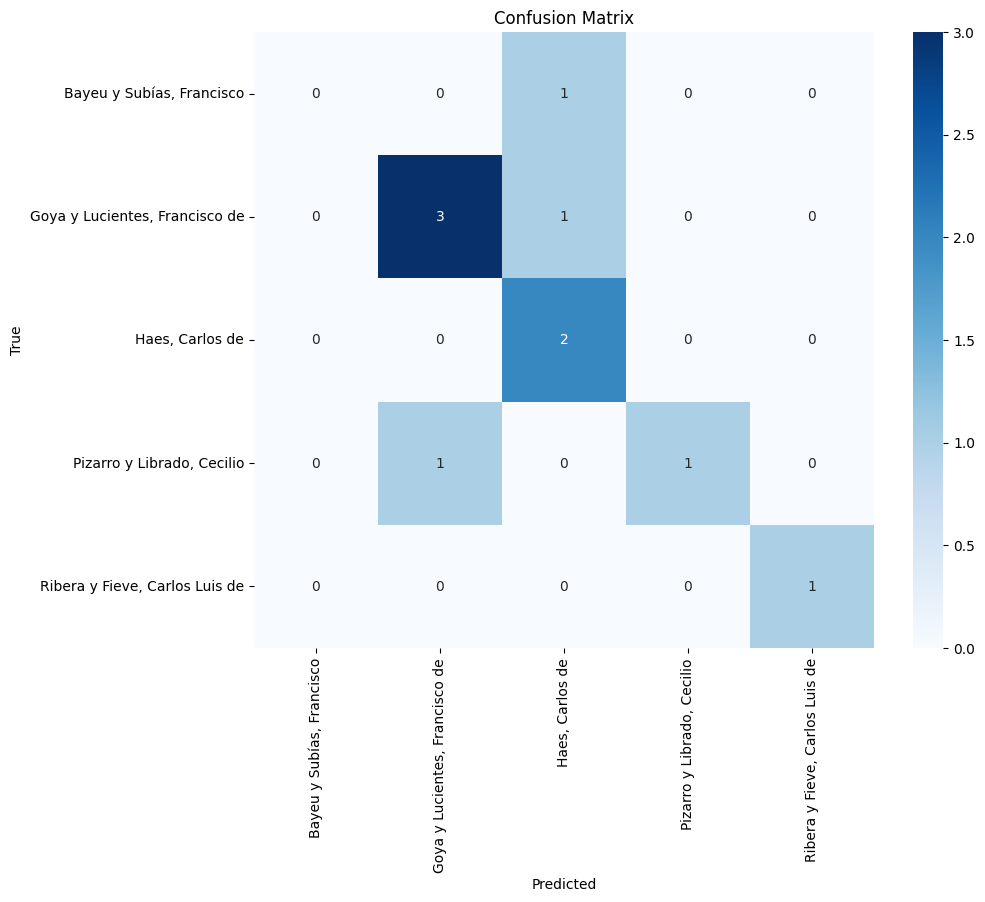

In [53]:
# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(trues, preds), annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [54]:
print(classification_report(trues, preds, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.7500    0.7500    0.7500         4
           2     0.5000    1.0000    0.6667         2
           3     1.0000    0.5000    0.6667         2
           4     1.0000    1.0000    1.0000         1

    accuracy                         0.7000        10
   macro avg     0.6500    0.6500    0.6167        10
weighted avg     0.7000    0.7000    0.6667        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
tf.keras.backend.clear_session()

# Base Model Augmented

In [56]:
# Model definition
def base_model_aug():
  model = Sequential()
  model.add(train_aug)

  model.add(layers.Rescaling(1./255, input_shape = (HEIGHT, WIDTH, 3)))

  model.add(layers.Conv2D(16, kernel_size=(3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(32, kernel_size=(3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, kernel_size=(3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(256, kernel_size=(3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Flatten())

  model.add(layers.Dense(256, activation = 'relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(len(classes)))

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy'])

  return model

In [57]:
base_model_aug = base_model_aug()
base_model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                   

In [58]:
# Training
base_model_aug_history = base_model_aug.fit(train_data,
                                            validation_data = validation_data,
                                            epochs = EPOCHS,
                                            class_weight = weights_class,
                                            callbacks=[early_stopping])

Epoch 1/20
30/30 [==============================] - 9s 230ms/step - loss: 1.5853 - accuracy: 0.2350 - val_loss: 1.7226 - val_accuracy: 0.3600
Epoch 2/20
30/30 [==============================] - 5s 155ms/step - loss: 1.4644 - accuracy: 0.3483 - val_loss: 1.2478 - val_accuracy: 0.4550
Epoch 3/20
30/30 [==============================] - 5s 163ms/step - loss: 1.4745 - accuracy: 0.3467 - val_loss: 1.3210 - val_accuracy: 0.5550
Epoch 4/20
30/30 [==============================] - 6s 198ms/step - loss: 1.3660 - accuracy: 0.4367 - val_loss: 1.3222 - val_accuracy: 0.4850
Epoch 5/20
30/30 [==============================] - 5s 168ms/step - loss: 1.3210 - accuracy: 0.4567 - val_loss: 1.1915 - val_accuracy: 0.5300
Epoch 6/20
30/30 [==============================] - 6s 210ms/step - loss: 1.1502 - accuracy: 0.5317 - val_loss: 1.1730 - val_accuracy: 0.4750
Epoch 7/20
30/30 [==============================] - 5s 168ms/step - loss: 1.0820 - accuracy: 0.5367 - val_loss: 0.9856 - val_accuracy: 0.5950
Epoch 

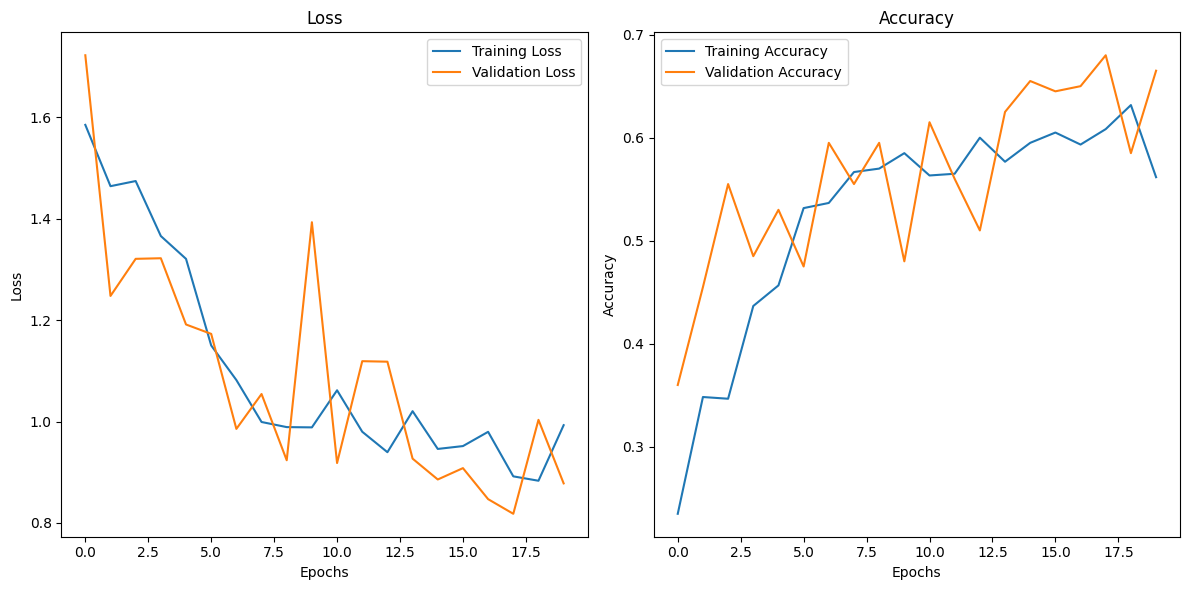

In [59]:
# Plotting performance model
history_df = pd.DataFrame(base_model_aug_history.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(history_df['loss'], label='Training Loss')
axes[0].plot(history_df['val_loss'], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_df['accuracy'], label='Training Accuracy')
axes[1].plot(history_df['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [60]:
# Prediction
trues = []
preds = []
for img, label in test_data:
  pred = base_model_aug.predict(img, verbose=0)
  pred = pred.argmax(axis=1)
  trues.append(label[0])
  preds.append(pred[0])

assert len(trues) == len(preds)

In [61]:
# Prediction measures results
print("F1-Score:", round(f1_score(trues, preds, average='micro', zero_division=1),3))
print("Recall score:", round(recall_score(trues, preds, average='micro', zero_division=1),3))
print("Precision score:", round(precision_score(trues, preds, average='micro', zero_division=1),3))

F1-Score: 0.6
Recall score: 0.6
Precision score: 0.6


In [62]:
# Model loss value & metrics values in test mode
base_model_aug.evaluate(test_data)

10/10 [==============================] - 5s 91ms/step - loss: 0.9700 - accuracy: 0.6150


[0.9700116515159607, 0.6150000095367432]

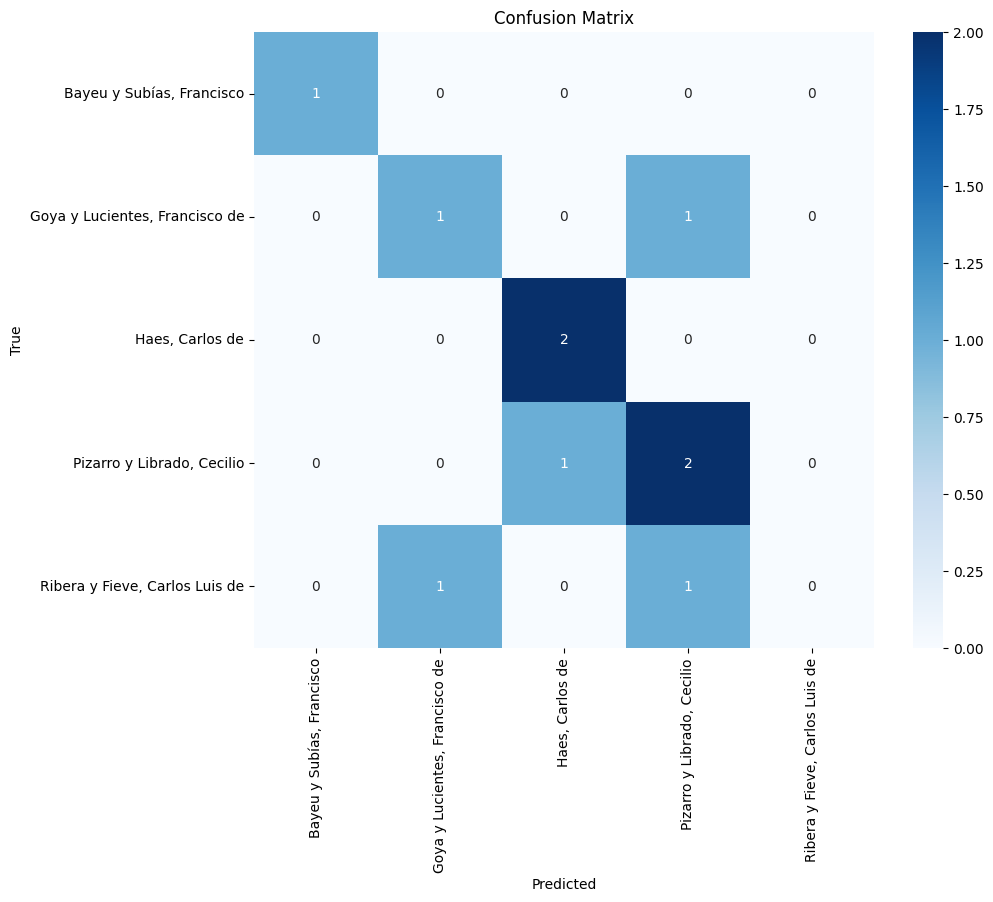

In [63]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(trues, preds), annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [64]:
print(classification_report(trues, preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     0.5000    0.5000    0.5000         2
           2     0.6667    1.0000    0.8000         2
           3     0.5000    0.6667    0.5714         3
           4     0.0000    0.0000    0.0000         2

    accuracy                         0.6000        10
   macro avg     0.5333    0.6333    0.5743        10
weighted avg     0.4833    0.6000    0.5314        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
tf.keras.backend.clear_session()

# Hyper Parameter Model

In [66]:
# Model definition
def hyp_mod(hp):
      model = Sequential()
      model.add(layers.Rescaling(1./255))

      model.add(layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16, sampling='linear'),
                              kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                              activation='relu',
                              input_shape=(HEIGHT, WIDTH, 3)))
      model.add(layers.MaxPooling2D())

      model.add(layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=16, max_value=128, step=16, sampling='linear'),
                              kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                              activation='relu'))
      model.add(layers.MaxPooling2D())

      model.add(layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=16, max_value=128, step=16, sampling='linear'),
                              kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
                              activation='relu'))
      model.add(layers.MaxPooling2D())

      model.add(layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=16, max_value=128, step=16, sampling='linear'),
                              kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
                              activation='relu'))
      model.add(layers.MaxPooling2D())

      model.add(layers.Flatten())

      model.add(layers.Dense(units=hp.Int('dense_1_units', min_value=16, max_value=256, step=16, sampling='linear'),
                             activation='relu'))

      model.add(layers.Dense(len(classes))) #, activation='softmax'


      model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
      return model

tuner = kt.Hyperband(hyp_mod,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='keras_tuner_demo2')

tuner.search(train_data,
             epochs=EPOCHS,
             validation_data=validation_data,
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Trial 23 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.625
Total elapsed time: 00h 09m 49s


In [67]:
# Selecting best performing model
model_hyp_tune = tuner.get_best_models(num_models=1)[0]

In [68]:
# Training
hyper_history = model_hyp_tune.fit(train_data,
                                   epochs=EPOCHS,
                                   validation_data=(validation_data),
                                   class_weight = weights_class,
                                   callbacks=[early_stopping])

Epoch 1/20
30/30 [==============================] - 17s 536ms/step - loss: 1.1644 - accuracy: 0.5150 - val_loss: 1.1320 - val_accuracy: 0.5550
Epoch 2/20
30/30 [==============================] - 18s 600ms/step - loss: 1.1328 - accuracy: 0.5100 - val_loss: 1.2457 - val_accuracy: 0.4100
Epoch 3/20
30/30 [==============================] - 16s 527ms/step - loss: 1.1057 - accuracy: 0.5533 - val_loss: 1.0323 - val_accuracy: 0.6300
Epoch 4/20
30/30 [==============================] - 17s 565ms/step - loss: 0.9811 - accuracy: 0.6400 - val_loss: 1.1170 - val_accuracy: 0.5300
Epoch 5/20
30/30 [==============================] - 16s 535ms/step - loss: 0.9090 - accuracy: 0.6450 - val_loss: 0.9380 - val_accuracy: 0.6400
Epoch 6/20
30/30 [==============================] - 19s 620ms/step - loss: 1.0411 - accuracy: 0.5967 - val_loss: 1.0564 - val_accuracy: 0.5700
Epoch 7/20
30/30 [==============================] - 16s 546ms/step - loss: 0.9121 - accuracy: 0.6567 - val_loss: 0.9316 - val_accuracy: 0.6400

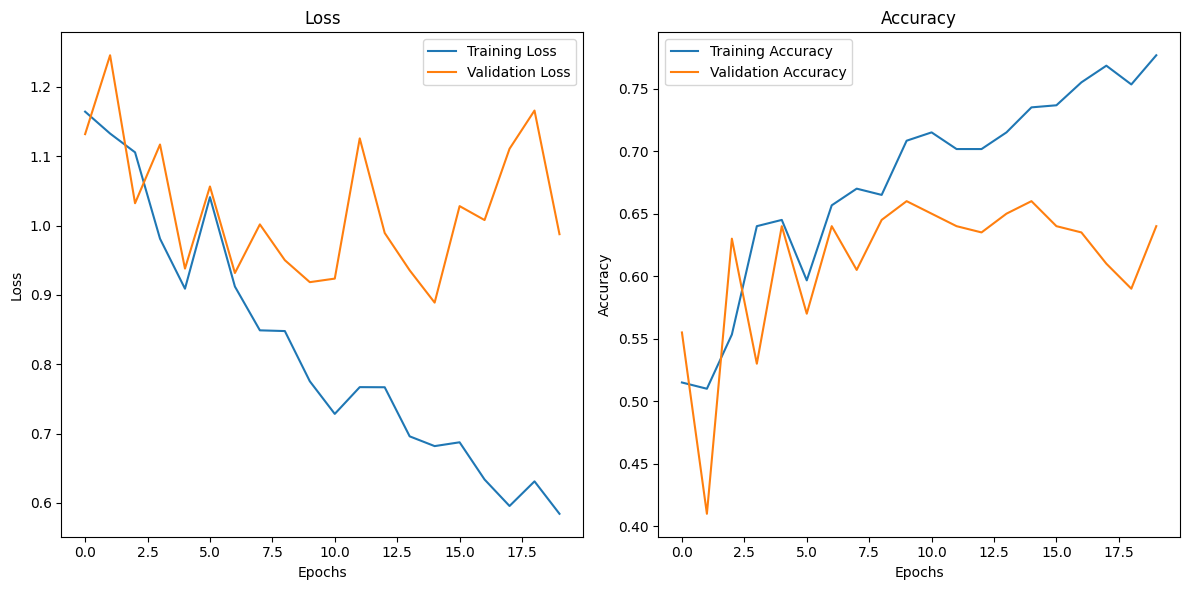

In [69]:
# Plotting performance model
history_df = pd.DataFrame(hyper_history.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(history_df['loss'], label='Training Loss')
axes[0].plot(history_df['val_loss'], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_df['accuracy'], label='Training Accuracy')
axes[1].plot(history_df['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [70]:
# Prediction
trues = []
preds = []
for img, label in test_data:
  pred = model_hyp_tune.predict(img, verbose=0)
  pred = pred.argmax(axis=1)
  trues.append(label[0])
  preds.append(pred[0])

assert len(trues) == len(preds)

In [71]:
# Prediction measures results
print("F1-Score:", round(f1_score(trues, preds, average='micro', zero_division=1),3))
print("Recall score:", round(recall_score(trues, preds, average='micro', zero_division=1),3))
print("Precision score:", round(precision_score(trues, preds, average='micro', zero_division=1),3))

F1-Score: 0.5
Recall score: 0.5
Precision score: 0.5


In [72]:
# Model loss value & metrics values in test mode
model_hyp_tune.evaluate(test_data)

10/10 [==============================] - 8s 273ms/step - loss: 1.1669 - accuracy: 0.6300


[1.166873812675476, 0.6299999952316284]

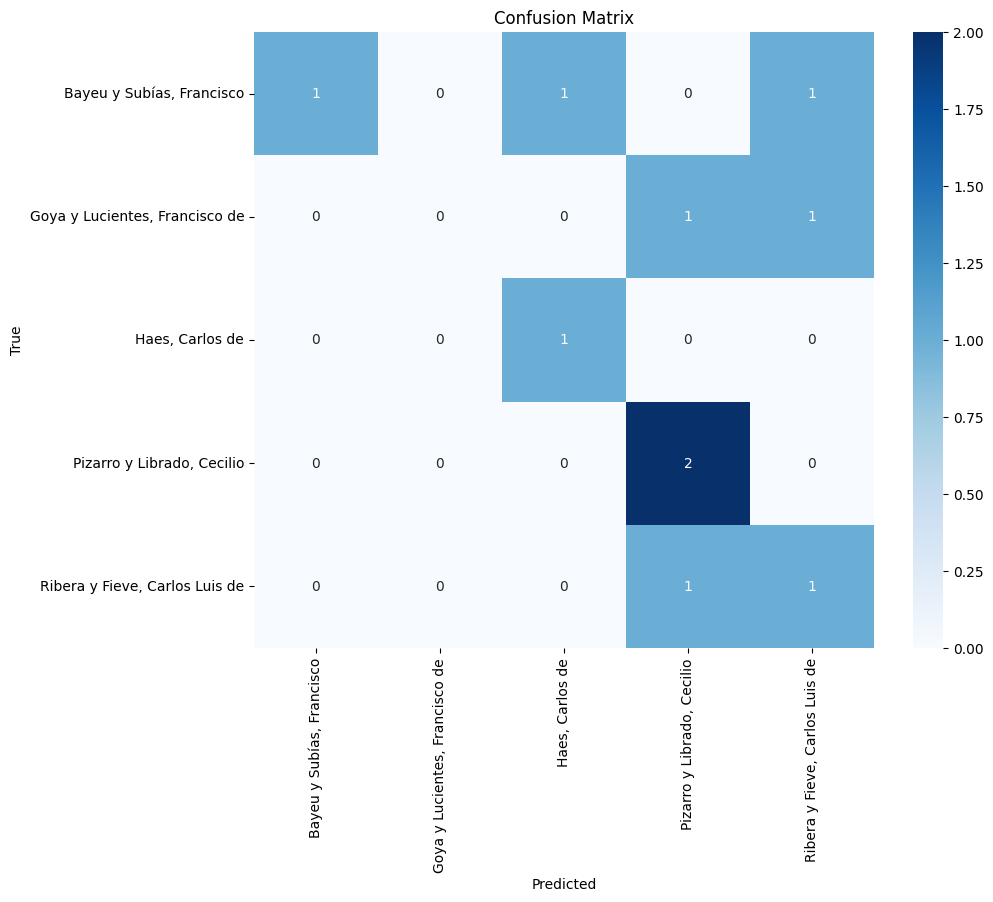

In [73]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(trues, preds), annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [74]:
print(classification_report(trues, preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.3333    0.5000         3
           1     0.0000    0.0000    0.0000         2
           2     0.5000    1.0000    0.6667         1
           3     0.5000    1.0000    0.6667         2
           4     0.3333    0.5000    0.4000         2

    accuracy                         0.5000        10
   macro avg     0.4667    0.5667    0.4467        10
weighted avg     0.5167    0.5000    0.4300        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
tf.keras.backend.clear_session()

# Time

In [76]:
end_time = time.time()
execution_time = round((end_time - start_time)/60)

print(f"Execution time: {execution_time} minutes")

Execution time: 33 minutes
